In [30]:
import pandas as pd
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# New York City Temperature Forecast

The aim of this notebook is to forecast NYC monthly temperature using Facebook's Prophet using Earth surface temperature data.

# Data set

The data is available here https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data

In [3]:
df = pd.read_csv('./../data/GlobalLandTemperaturesByCity.csv')
df = df[df.City == 'New York']

# Pre-processing

Filter data by date (using recent surface temperature: after 1970).

In [4]:
df['dt'] = pd.to_datetime(df['dt'])

df = df[df.dt >= '1970-01-01']

Select only average temperature

In [ ]:
df = df[['dt', 'AverageTemperature']]

# Feature engineering

**Add lags variable**

In [5]:
# Adding the lag of the target variable from 6 steps back up to 24
for i in range(6, 25):
    df["lag_{}".format(i)] = df.AverageTemperature.shift(i)

**Add exogene variables**

* 1st exogene variable is GDP of USA https://data.oecd.org/gdp/gross-domestic-product-gdp.htm

In [6]:
indicator = pd.read_csv('./../data/DP_LIVE_07102020175736186.csv')

indicator = indicator[indicator.LOCATION == 'USA']

indicator.head(1)

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
2833,USA,GDP,TOT,MLN_USD,A,1970,1073303.0,NaN


Select columns for the model

In [7]:
indicator = indicator[indicator['MEASURE'] == 'MLN_USD']
indicator = indicator[['Value', 'TIME']]
indicator['Value_shifted'] = indicator['Value'].shift(1)
indicator = indicator.drop(columns=['Value'])

Merge

In [8]:
df['year'] = df['dt'].dt.year

df = pd.merge(df, indicator, how = 'left', left_on ='year', right_on ='TIME')

* 2nd exogene variable is co2 emission volume (t) https://ourworldindata.org/co2-emissions

In [9]:
co2 = pd.read_csv('./../data/annual-co2-emissions-per-country.csv')

co2 = co2[co2.Code == 'USA'][['Year', 'Annual CO2 emissions']]

co2['Annual CO2 emissions'] = co2['Annual CO2 emissions'].shift(1)

co2 = co2[co2.Year >= 1970]

Merge

In [10]:
df = pd.merge(df, co2, how = 'left', left_on ='year', right_on ='Year')

df = df.drop(columns=['Year', 'year', 'TIME'])

**Create month variable**

In [12]:
df['month'] = df['dt'].dt.month

**Create age variable**

This variable lets us to detect turning point

In [11]:
df['age'] = [i for i in range(0,df.shape[0])]

# Machine learning

**Time series cross-validation**

In [16]:
# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [17]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [18]:
df.head()

,dt,AverageTemperature,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,...,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,Value_shifted,Annual CO2 emissions,age,month
0,1970-01-01,-7.058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4021.502617,0,1
1,1970-02-01,-2.163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4021.502617,1,2
2,1970-03-01,1.237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4021.502617,2,3
3,1970-04-01,8.670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4021.502617,3,4
4,1970-05-01,15.856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4021.502617,4,5


**Scaler**

In [19]:
df = df.set_index('dt')

In [23]:
scaler = MinMaxScaler()
df[['Value_shifted', 'Annual CO2 emissions']] = scaler.fit_transform(df[['Value_shifted', 'Annual CO2 emissions']])

In [24]:
y = df.dropna().AverageTemperature
X = df.dropna().drop(['AverageTemperature'], axis=1)

For Train/ Val/ Test sets, keep:
* 12 months data for test
* 48 months data before test for validation
* rest for training

In [25]:
X_train = X[:-60].copy()
X_val = X[-60:-12].copy()
X_test = X[-12:].copy()
y_train = y[:-60].copy()
y_val = y[-60:-12].copy()
y_test = y[-12:].copy()

## Linear regression

**Fit**

In [26]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [27]:
def measure_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))

**Plot results**

In [28]:
def plotModelResults(model, X_train=X_train, X_val=X_val, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_val)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_val.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_val<lower] = y_val[y_test<lower]
            anomalies[y_val>upper] = y_val[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = measure_rmse(prediction, y_val)
    plt.title("RMSE {0:.2f}".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

We:
* Calculate RMSE
* plot upper bond, lower bond and prediction
* plot sorted linear regression 

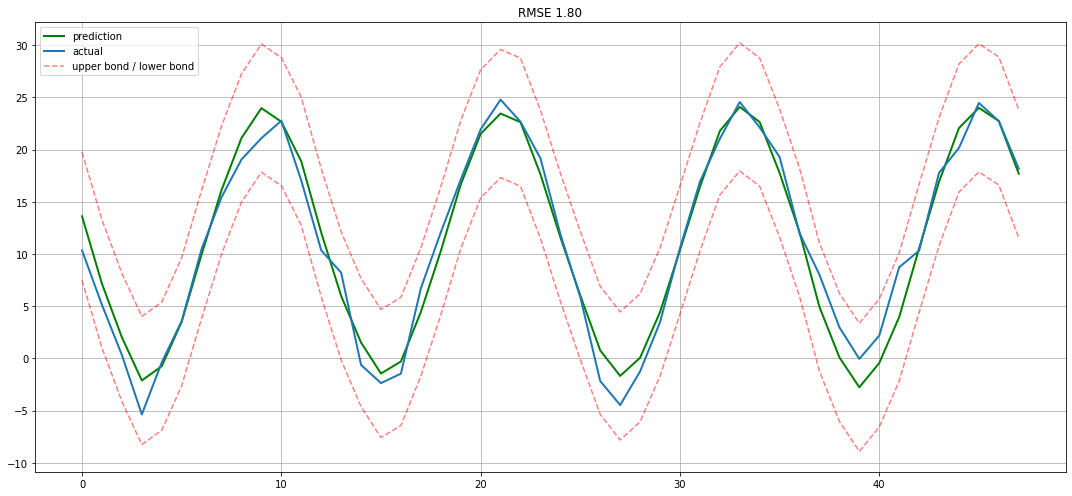

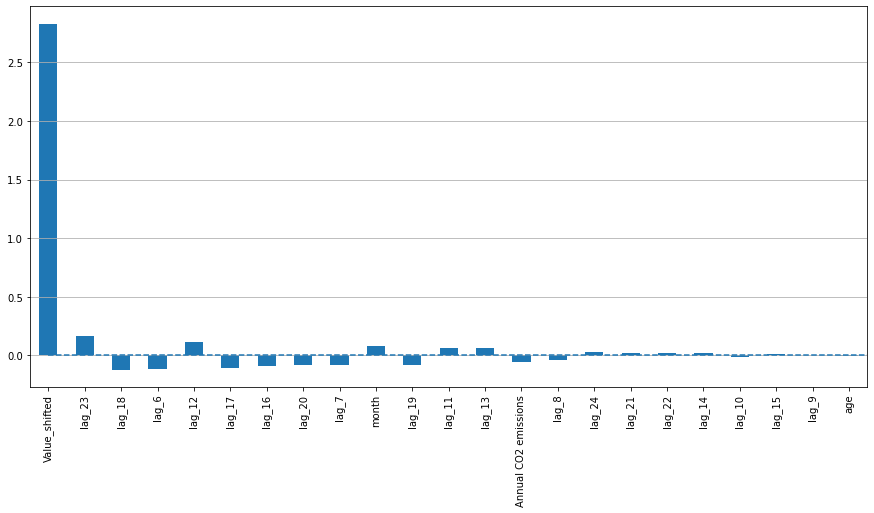

In [336]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

GDP and temperature lags variables seem to be important to predict temperature

# Random Forest

**Fit**

In [31]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

**Plot results**

The random forest seems to be less performant than linear regression: higher RMSE, graphically more important difference between prediction and reality

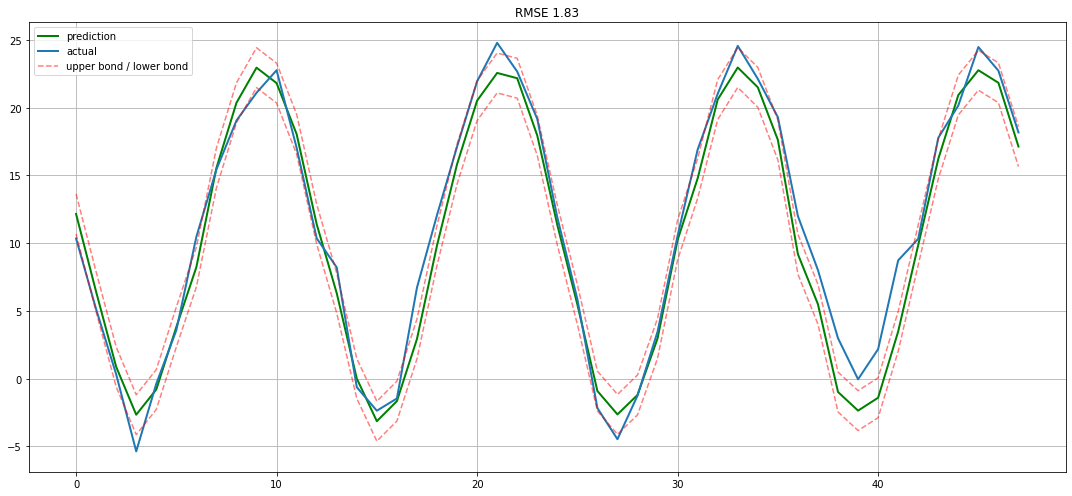

In [32]:
plotModelResults(rf, plot_intervals=True)

**Feature importances**

we sort feature importances by gini index

In [33]:
feats = {}
for feature, importance in zip(X_train.columns, rf.feature_importances_):
    feats[feature] = importance #add the name/value pair 

<AxesSubplot:>

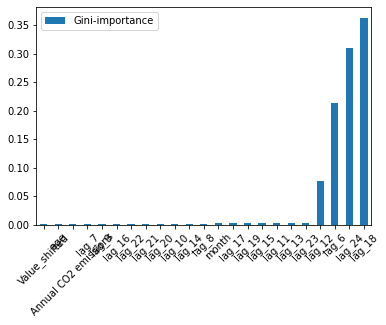

In [34]:
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)

Lags variables seem to be the most important features for random forest. Exogene variables have less impact

**Intelligibility**

We use SHAP values to explain each point of predictions. Inded, SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value.

In [35]:
import shap

In [36]:
shap.initjs()

In [37]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_val)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_val.iloc[0,:])

We see that lag_18 attirbutes positively (and mostly) in the value of the first prediction. In the same way lag_24 attributs negatively in the value of the first prediction. If you add all the shap values and the baseline (the mean value of target values) we obtain the prediction value.